### Import necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score

import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Load Dataset


In [2]:
# https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD&guccounter=1
data = pd.read_csv('../data/BTC-USD.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,6317.609863,4191240000
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,6377.779785,3789400000
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,6388.439941,4234870000
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,6361.259766,3658640000
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,6376.129883,4390020000


In [3]:
data.shape

(1827, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1827 non-null   object 
 1   Open       1827 non-null   float64
 2   High       1827 non-null   float64
 3   Low        1827 non-null   float64
 4   Close      1827 non-null   float64
 5   Adj Close  1827 non-null   float64
 6   Volume     1827 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 100.0+ KB


In [5]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,23399.509982,23937.344490,22818.715253,23412.610651,23412.610651,2.849508e+10
std,16202.844316,16619.593375,15719.217682,16195.608850,16195.608850,1.855361e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,3.551764e+09
25%,9275.281250,9413.937500,9156.262207,9278.387695,9278.387695,1.642343e+10
50%,20242.289063,20724.980469,19848.078125,20280.634766,20280.634766,2.545047e+10
75%,34036.814453,34876.597657,32734.328125,34025.847657,34025.847657,3.615833e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [6]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

### EDA


In [8]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.head()

,date,open,high,low,close,adj_close,volume
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,6317.609863,4191240000
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,6377.779785,3789400000
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,6388.439941,4234870000
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,6361.259766,3658640000
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,6376.129883,4390020000


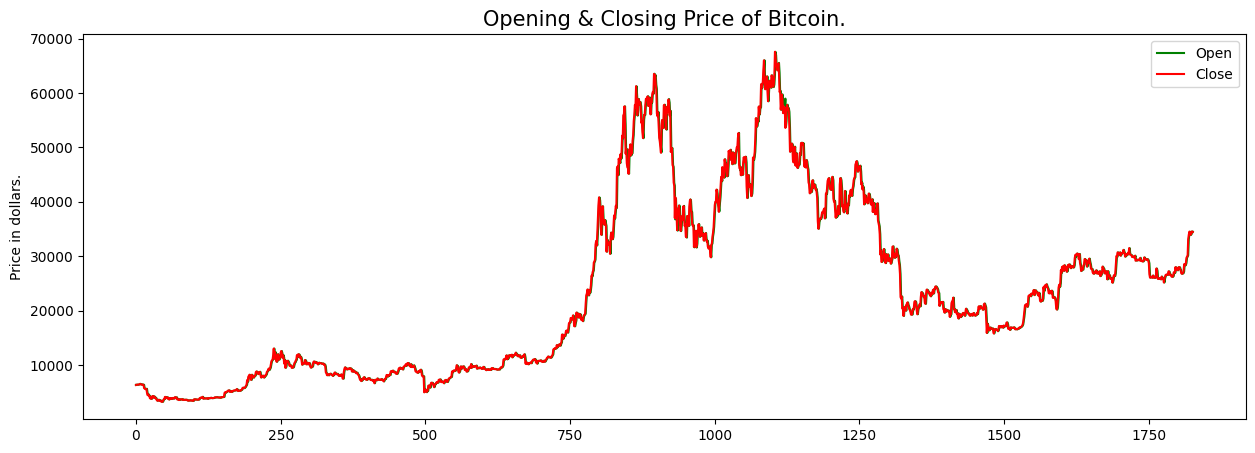

In [9]:

plt.figure(figsize=(15, 5))
plt.plot(data['open'], color='green', label='Open')
plt.plot(data['close'], color='red', label='Close')
plt.title('Opening & Closing Price of Bitcoin.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.legend()
plt.show()

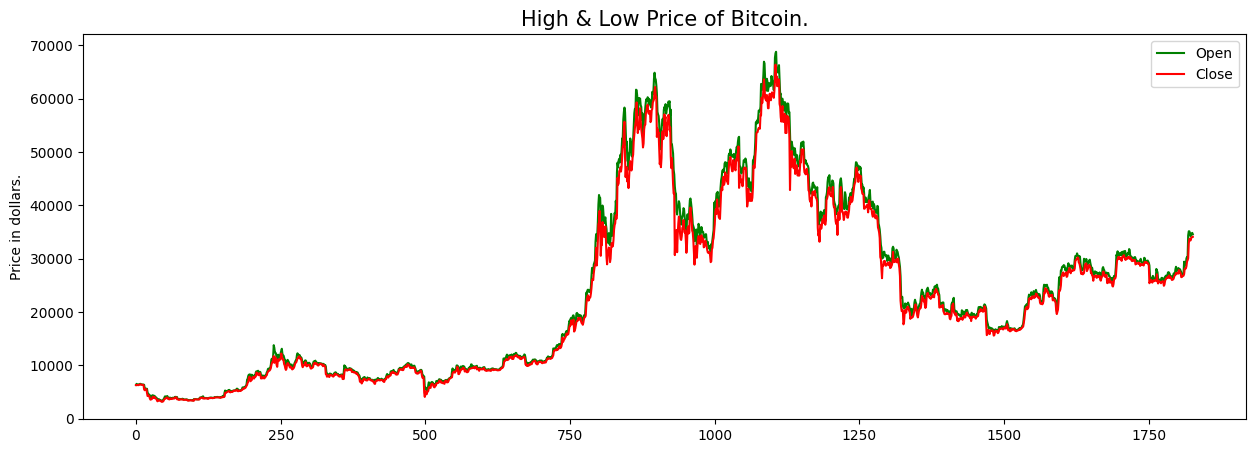

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(data['high'], color='green', label='Open')
plt.plot(data['low'], color='red', label='Close')
plt.title('High & Low Price of Bitcoin.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.legend()
plt.show()

In [11]:
data[data['close'] == data['adj_close']].shape, data.shape

((1827, 7), (1827, 7))

In [12]:
# drop adj_close columns cause all the rows of columns ‘close’ and ‘adj_close’ have the same data
data = data.drop(['adj_close'], axis=1)

In [13]:
num_features = ['open', 'high', 'low', 'close']
data[num_features].corr()

,open,high,low,close
open,1.000000,0.999159,0.998515,0.997997
high,0.999159,1.000000,0.998290,0.999096
low,0.998515,0.998290,1.000000,0.998940
close,0.997997,0.999096,0.998940,1.000000


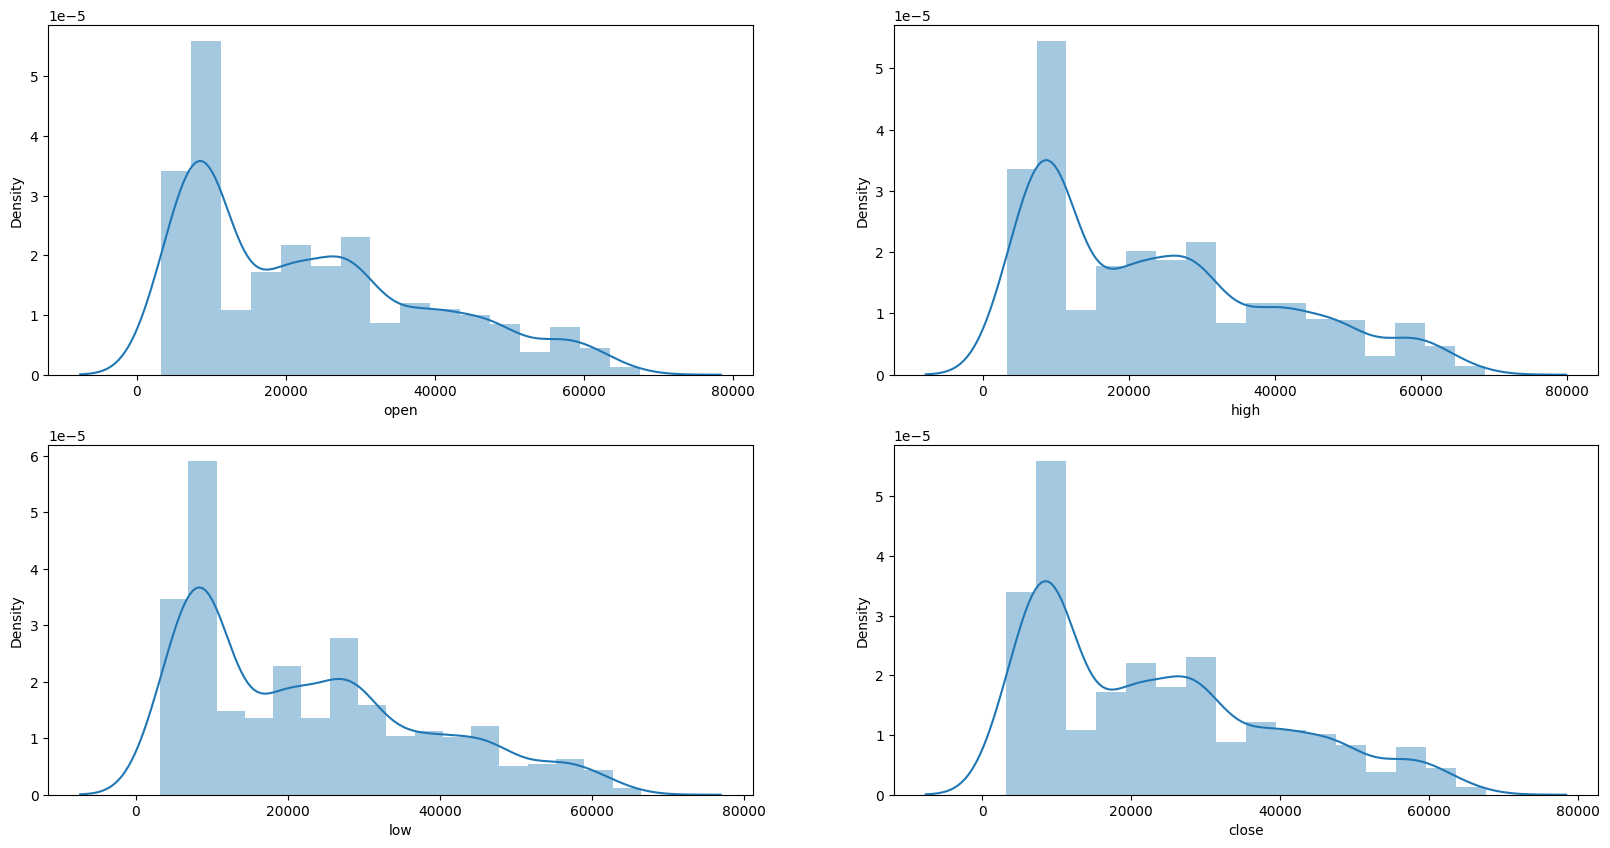

In [391]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i, (col, ax) in enumerate(zip(num_features, axes.flatten())):
    sns.distplot(data[col], ax=ax)

plt.show()

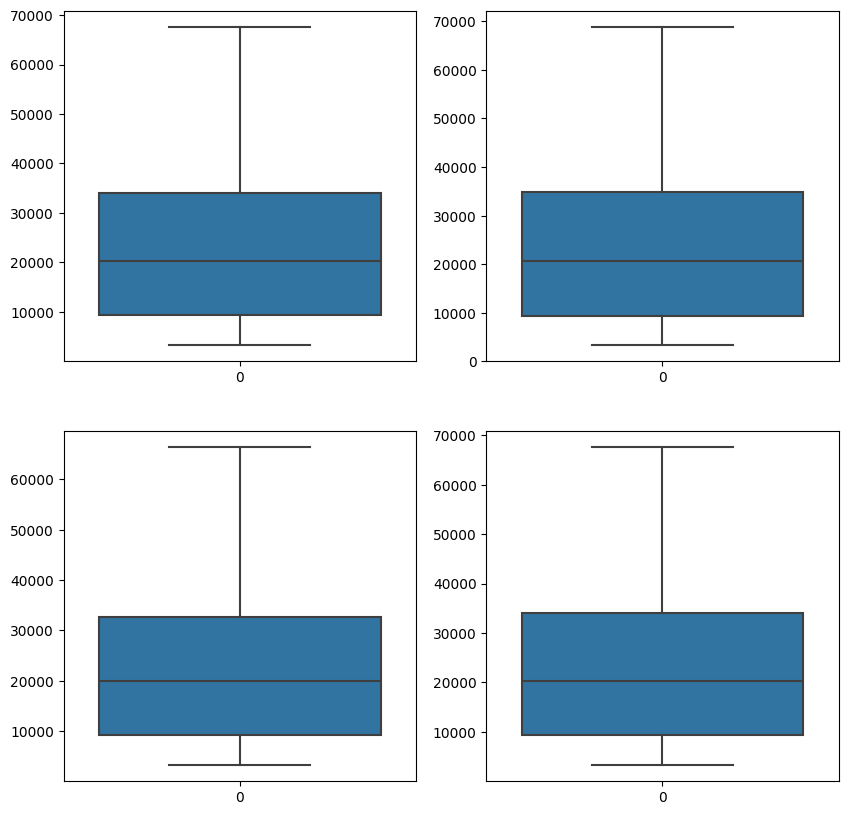

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, (col, ax) in enumerate(zip(num_features, axes.flatten())):
    sns.boxplot(data[col], ax=ax)

plt.show()

### Prepare data for classification

Attach a label to each movement:

- 1 if the signal is that short term price will go up as compared to the long term.
- 0 if the signal is that short term price will go down as compared to the long term.


In [263]:
df = data.copy()
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')

In [264]:
# Initialize the `signals` DataFrame with the `signal` column

# Create short simple moving average over the short window
df['short_mavg'] = df['close'].rolling(
    window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
df['long_mavg'] = df['close'].rolling(
    window=60, min_periods=1, center=False).mean()

# Create signals
df['signals'] = np.where(df['short_mavg'] > df['long_mavg'], 1, 0)

In [265]:
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,4191240000,6317.609863,6317.609863,0
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,3789400000,6347.694824,6347.694824,0
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,4234870000,6361.276530,6361.276530,0
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,3658640000,6361.272339,6361.272339,0
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,4390020000,6364.243848,6364.243848,0


In [266]:
df.tail()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals
1822,2023-10-27,34156.500000,34238.210938,33416.886719,33909.800781,16418032871,31620.043750,27579.579557,1
1823,2023-10-28,33907.722656,34399.390625,33874.804688,34089.574219,10160330825,32196.166992,27685.615918,1
1824,2023-10-29,34089.371094,34743.261719,33947.566406,34538.480469,11160323986,32778.034375,27806.302832,1
1825,2023-10-30,34531.742188,34843.933594,34110.972656,34502.363281,17184860315,33259.975781,27949.151009,1
1826,2023-10-31,34500.078125,34598.324219,34113.550781,34440.511719,16038452224,33712.185742,28093.147461,1


In [267]:
df[df['signals'] == 1].shape, df[df['signals'] == 0].shape

((919, 9), (908, 9))

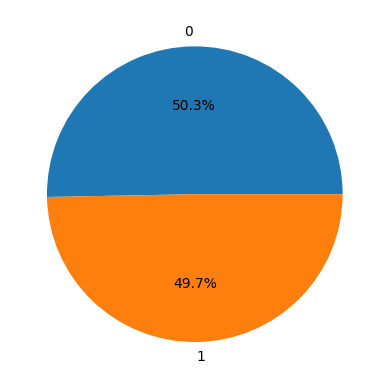

In [268]:
plt.pie(df['signals'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

### Feature Engineering


Constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and volume. Using this data we calculate the following technical indicators:

- Moving Average : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.
- Stochastic Oscillator %K and %D : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
- Relative Strength Index(RSI) :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
- Rate Of Change(ROC): It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
  Momentum (MOM) : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.


In [269]:
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,4191240000,6317.609863,6317.609863,0
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,3789400000,6347.694824,6347.694824,0
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,4234870000,6361.276530,6361.276530,0
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,3658640000,6361.272339,6361.272339,0
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,4390020000,6364.243848,6364.243848,0


In [270]:
# calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(
        span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA


df['EMA7'] = EMA(df, 7)
df['EMA14'] = EMA(df, 14)
df['EMA30'] = EMA(df, 30)
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals,EMA7,EMA14,EMA30
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,4191240000,6317.609863,6317.609863,0,NaN,NaN,NaN
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,3789400000,6347.694824,6347.694824,0,NaN,NaN,NaN
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,4234870000,6361.276530,6361.276530,0,NaN,NaN,NaN
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,3658640000,6361.272339,6361.272339,0,NaN,NaN,NaN
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,4390020000,6364.243848,6364.243848,0,NaN,NaN,NaN


In [271]:
# calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
    return ROC

df['ROC7'] = ROC(df['close'], 7)
df['ROC14'] = ROC(df['close'], 14)
df['ROC30'] = ROC(df['close'], 30)
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals,EMA7,EMA14,EMA30,ROC7,ROC14,ROC30
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,4191240000,6317.609863,6317.609863,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,3789400000,6347.694824,6347.694824,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,4234870000,6361.276530,6361.276530,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,3658640000,6361.272339,6361.272339,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,4390020000,6364.243848,6364.243848,0,NaN,NaN,NaN,NaN,NaN,NaN


In [272]:
# Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM

df['MOM7'] = MOM(df['close'], 7)
df['MOM14'] = MOM(df['close'], 14)
df['MOM30'] = MOM(df['close'], 30)
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals,EMA7,EMA14,EMA30,ROC7,ROC14,ROC30,MOM7,MOM14,MOM30
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,4191240000,6317.609863,6317.609863,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,3789400000,6347.694824,6347.694824,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,4234870000,6361.276530,6361.276530,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,3658640000,6361.272339,6361.272339,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,4390020000,6364.243848,6364.243848,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
# calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    # first value is sum of avg gains
    u[u.index[period-1]] = np.mean(u[:period])
    u = u.drop(u.index[:(period-1)])
    # first value is sum of avg losses
    d[d.index[period-1]] = np.mean(d[:period])
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
        d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)


df['RSI7'] = RSI(df['close'], 7)
df['RSI14'] = RSI(df['close'], 14)
df['RSI30'] = RSI(df['close'], 30)
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals,EMA7,...,EMA30,ROC7,ROC14,ROC30,MOM7,MOM14,MOM30,RSI7,RSI14,RSI30
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,4191240000,6317.609863,6317.609863,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,3789400000,6347.694824,6347.694824,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,4234870000,6361.276530,6361.276530,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,3658640000,6361.272339,6361.272339,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,4390020000,6364.243848,6364.243848,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
# calculation of stochastic osillator.
def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) /
            (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK


def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) /
            (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


df['%K7'] = STOK(df['close'], df['low'], df['high'], 7)
df['%D7'] = STOD(df['close'], df['low'], df['high'], 7)

df['%K14'] = STOK(df['close'], df['low'], df['high'], 14)
df['%D14'] = STOD(df['close'], df['low'], df['high'], 14)

df['%K30'] = STOK(df['close'], df['low'], df['high'], 30)
df['%D30'] = STOD(df['close'], df['low'], df['high'], 30)
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals,EMA7,...,MOM30,RSI7,RSI14,RSI30,%K7,%D7,%K14,%D14,%K30,%D30
0,2018-10-31,6336.990234,6349.160156,6316.879883,6317.609863,4191240000,6317.609863,6317.609863,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-11-01,6318.140137,6547.140137,6311.830078,6377.779785,3789400000,6347.694824,6347.694824,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-11-02,6378.919922,6396.859863,6327.379883,6388.439941,4234870000,6361.276530,6361.276530,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-11-03,6387.240234,6400.069824,6342.370117,6361.259766,3658640000,6361.272339,6361.272339,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-11-04,6365.470215,6388.629883,6294.569824,6376.129883,4390020000,6364.243848,6364.243848,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [275]:
df.isnull().sum()

date           0
open           0
high           0
low            0
close          0
volume         0
short_mavg     0
long_mavg      0
signals        0
EMA7           6
EMA14         13
EMA30         29
ROC7           6
ROC14         13
ROC30         29
MOM7           7
MOM14         14
MOM30         30
RSI7           7
RSI14         14
RSI30         30
%K7            6
%D7            8
%K14          13
%D14          15
%K30          29
%D30          31
dtype: int64

In [276]:
df = df.dropna(axis=0)
df.shape

(1796, 27)

In [279]:
df.reset_index(drop=True, inplace=True)
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals,EMA7,...,MOM30,RSI7,RSI14,RSI30,%K7,%D7,%K14,%D14,%K30,%D30
0,2018-12-01,4024.464355,4309.377441,3969.710693,4214.671875,5375314093,4097.183667,5395.618340,0,4170.663233,...,-2163.107910,42.674729,34.694533,27.852213,76.043707,70.676188,30.437353,28.272062,21.219770,19.723039
1,2018-12-02,4200.733398,4301.519531,4110.978516,4139.877930,5262697895,4074.577466,5357.565600,0,4162.966327,...,-2248.562011,40.220621,33.593449,27.388947,64.485454,64.242126,27.254138,26.195256,18.698994,18.161821
2,2018-12-03,4147.323730,4155.979492,3840.446289,3894.130859,5089570994,4029.279566,5314.523402,0,4095.753662,...,-2467.128907,32.955819,30.201882,25.923375,30.999680,57.176280,22.616871,26.769454,10.416595,16.778453
3,2018-12-04,3886.294922,4075.627686,3832.750000,3956.893799,5028069239,4036.892945,5275.733984,0,4061.037225,...,-2419.236084,36.379803,32.087675,26.956028,22.762460,39.415865,34.092234,27.987748,12.531891,13.882493
4,2018-12-05,3958.894775,3969.535889,3753.994873,3753.994873,5302481574,4011.295435,5233.463454,0,3984.274197,...,-2665.665283,30.504187,29.328953,25.755313,0.000000,17.920713,16.172510,24.293871,5.693600,9.547362


In [280]:
df['year'] = df.date.dt.year
# df['month'] = df.date.dt.month
# df['day'] = df.date.dt.day
# df['quarter'] = df.date.dt.quarter
# df['day_of_week'] = df['date'].dt.dayofweek
# df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)  # 1 for weekend, 0 for weekdays

# del df['date']

In [281]:
# df.columns.to_list()
features = [
    'EMA7',
    'EMA14',
    'EMA30',
    'ROC7',
    'ROC14',
    'ROC30',
    'MOM7',
    'MOM14',
    'MOM30',
    'RSI7',
    'RSI14',
    'RSI30',
    '%K7',
    '%D7',
    '%K14',
    '%D14',
    '%K30',
    '%D30'
    ]

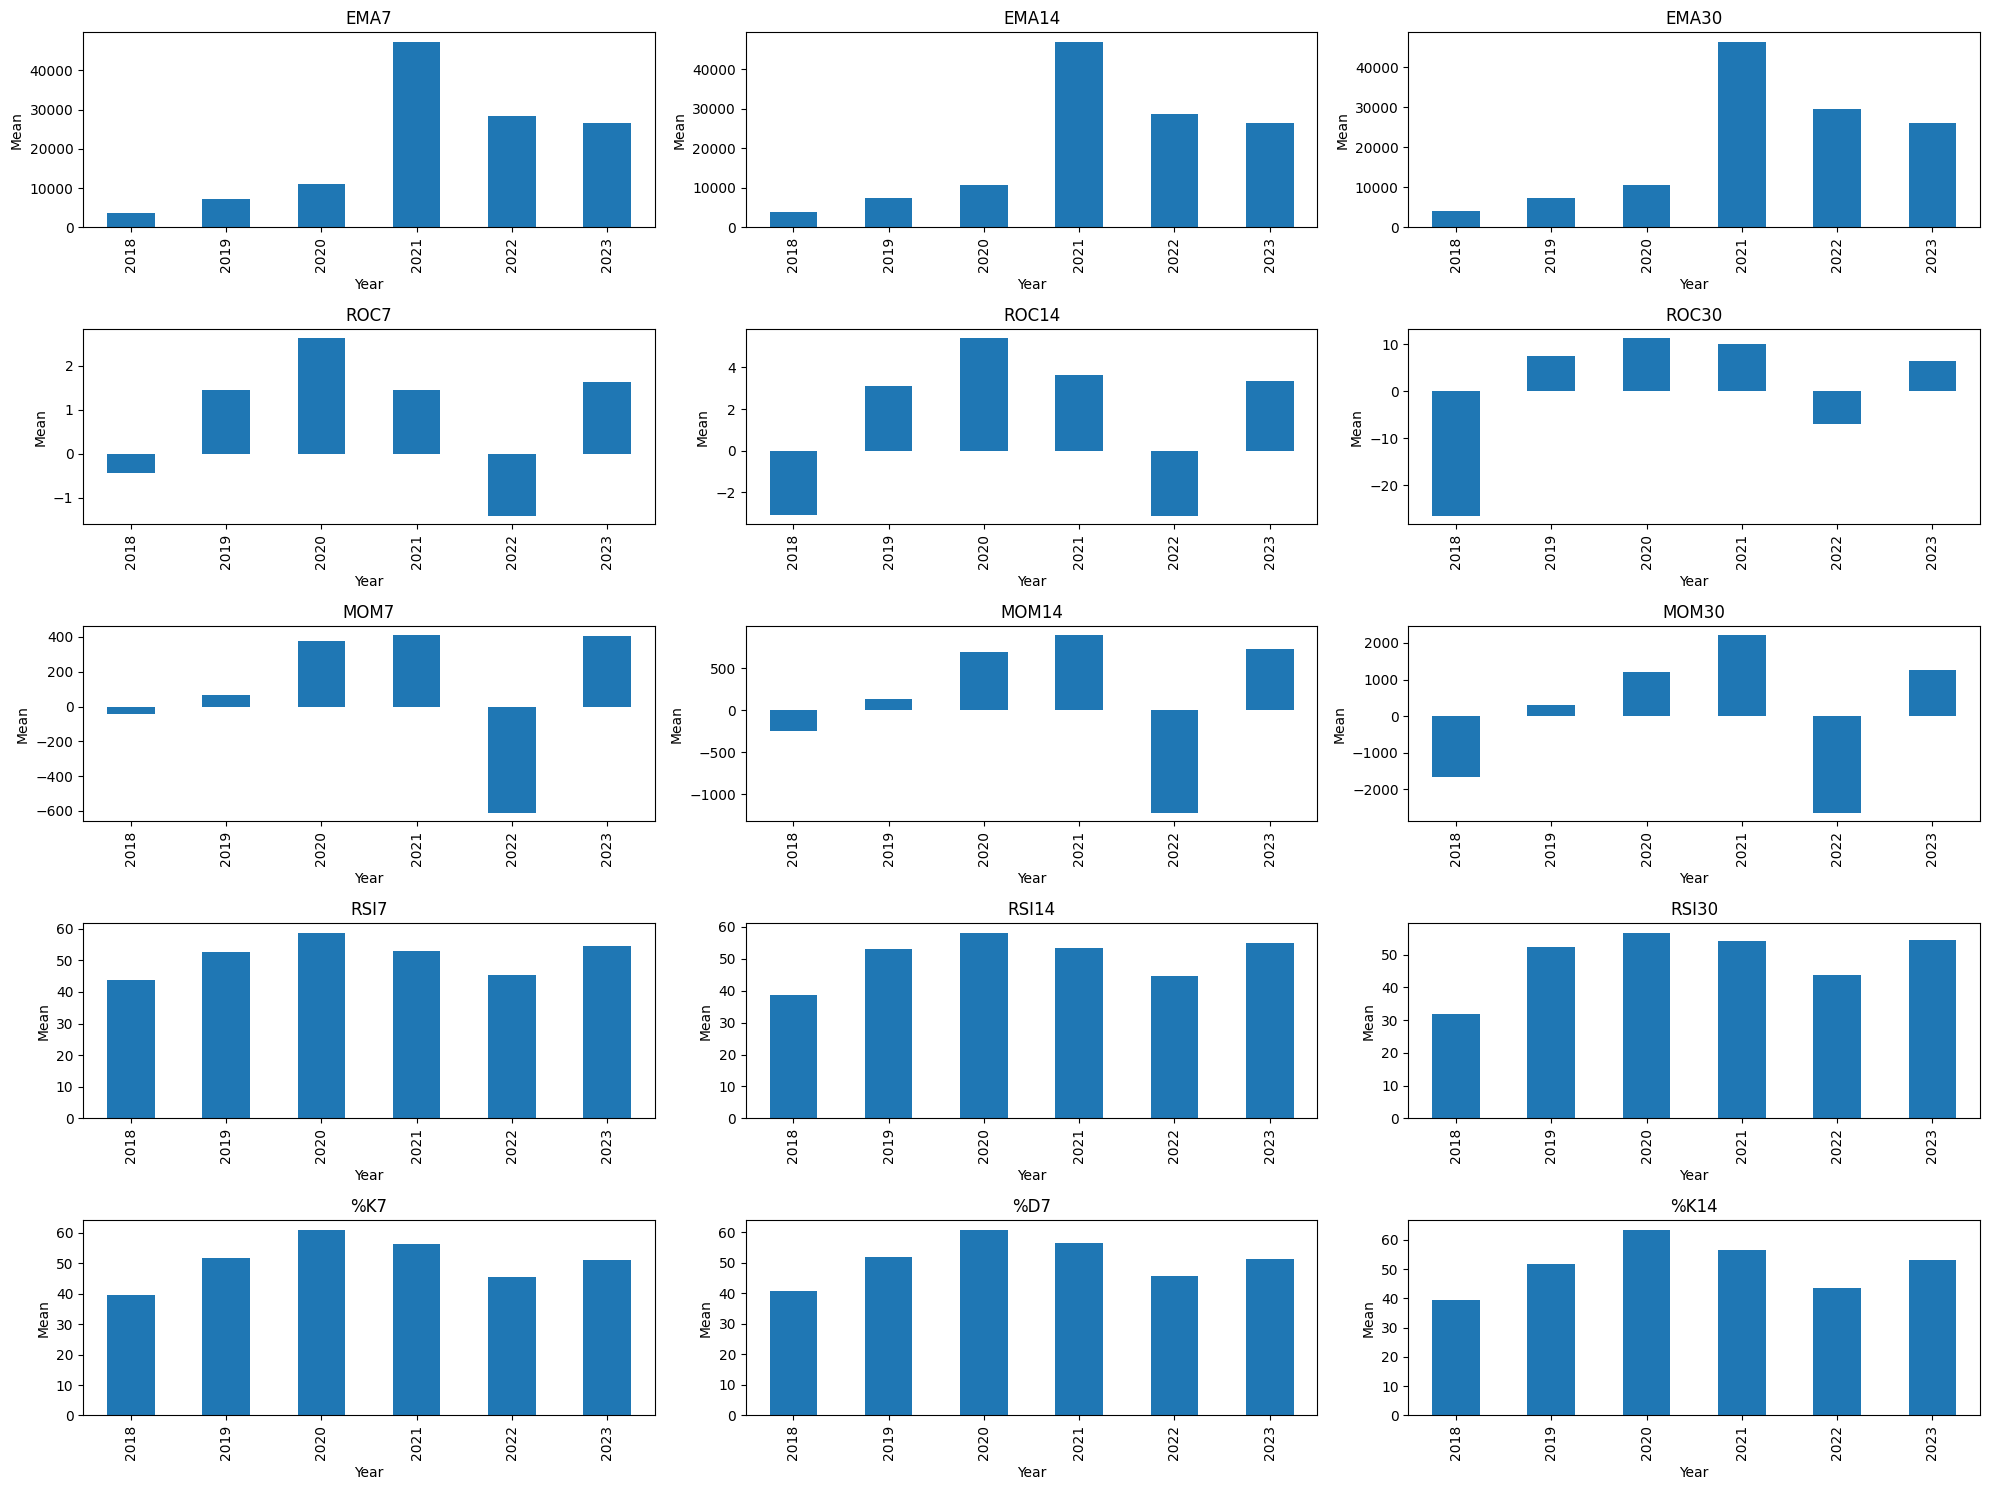

In [282]:
data_grouped = df.groupby('year')[features].mean()

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 15))
for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    data_grouped[col].plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Mean')
    ax.set_xlabel('Year')

plt.tight_layout()
plt.show()

In [258]:
df.isnull().sum()

date          0
open          0
high          0
low           0
close         0
volume        0
short_mavg    0
long_mavg     0
signals       0
EMA7          0
EMA14         0
EMA30         0
ROC7          0
ROC14         0
ROC30         0
MOM7          0
MOM14         0
MOM30         0
RSI7          0
RSI14         0
RSI30         0
%K7           0
%D7           0
%K14          0
%D14          0
%K30          0
%D30          0
year          0
dtype: int64

In [286]:
df.head()

,date,open,high,low,close,volume,short_mavg,long_mavg,signals,EMA7,...,RSI7,RSI14,RSI30,%K7,%D7,%K14,%D14,%K30,%D30,year
0,2018-12-01,4024.464355,4309.377441,3969.710693,4214.671875,5375314093,4097.183667,5395.618340,0,4170.663233,...,42.674729,34.694533,27.852213,76.043707,70.676188,30.437353,28.272062,21.219770,19.723039,2018
1,2018-12-02,4200.733398,4301.519531,4110.978516,4139.877930,5262697895,4074.577466,5357.565600,0,4162.966327,...,40.220621,33.593449,27.388947,64.485454,64.242126,27.254138,26.195256,18.698994,18.161821,2018
2,2018-12-03,4147.323730,4155.979492,3840.446289,3894.130859,5089570994,4029.279566,5314.523402,0,4095.753662,...,32.955819,30.201882,25.923375,30.999680,57.176280,22.616871,26.769454,10.416595,16.778453,2018
3,2018-12-04,3886.294922,4075.627686,3832.750000,3956.893799,5028069239,4036.892945,5275.733984,0,4061.037225,...,36.379803,32.087675,26.956028,22.762460,39.415865,34.092234,27.987748,12.531891,13.882493,2018
4,2018-12-05,3958.894775,3969.535889,3753.994873,3753.994873,5302481574,4011.295435,5233.463454,0,3984.274197,...,30.504187,29.328953,25.755313,0.000000,17.920713,16.172510,24.293871,5.693600,9.547362,2018


In [287]:
features_columns = features

result = {}

for feature in features_columns:
    correlation = df[[feature]].corrwith(df.signals)
    result[feature] = correlation[feature]
    
    
corr_df = pd.DataFrame(result.items(), columns=['Feature', 'Correlation with Target'])
corr_df

,Feature,Correlation with Target
0,EMA7,0.083532
1,EMA14,0.059582
2,EMA30,0.006274
3,ROC7,0.212050
4,ROC14,0.440605
5,ROC30,0.660099
6,MOM7,0.206828
7,MOM14,0.393229
8,MOM30,0.579537
9,RSI7,0.420639


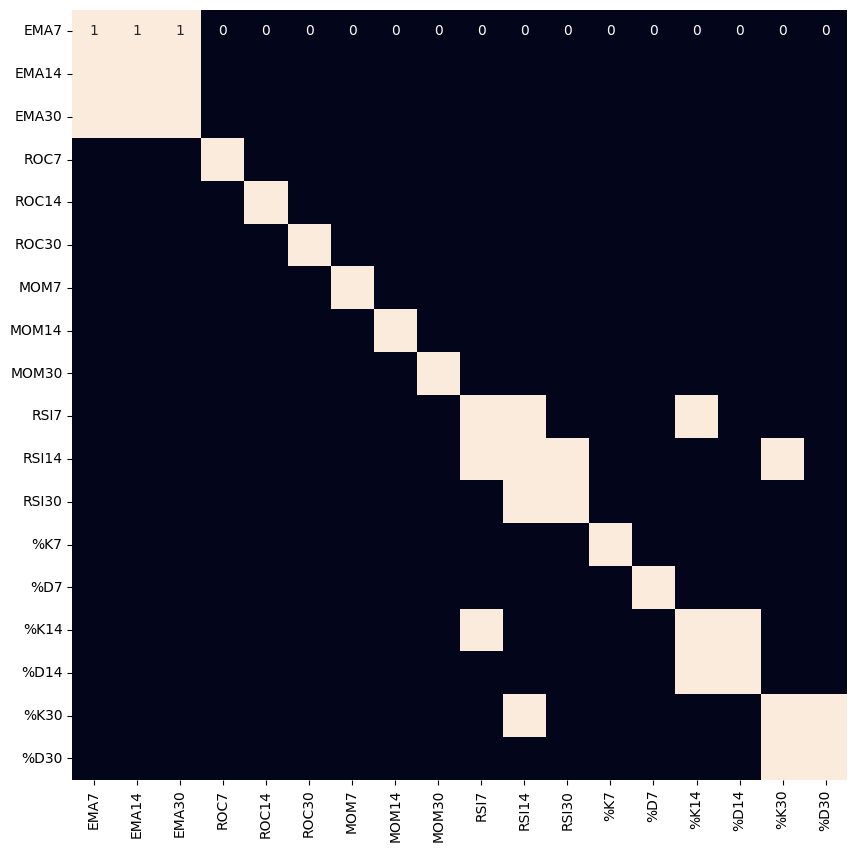

In [288]:
#@ visualize heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df[features_columns].corr() > 0.9, annot=True, cbar=False)
plt.show()

In [326]:
# split_data
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train), len(df_val), len(df_test)

(1347, 449, 360)

In [328]:
# def split_dataframe(df, train_fraction=0.8):
#     split_index = int(train_fraction * len(df))
#     df_train = df[:split_index].reset_index(drop=True)
#     df_test = df[split_index:].reset_index(drop=True)
#     return df_train, df_test


# df_train_full, df_test = split_dataframe(df, train_fraction=0.8)
# df_train, df_val = split_dataframe(df_train_full, train_fraction=0.75)

# len(df_train), len(df_val), len(df_test)

In [330]:
y_train = df_train.signals.values
y_val = df_val.signals.values
y_test = df_test.signals.values

### Model Training and Evaluation

In [331]:
train_dict = df_train[features].to_dict(orient="records")
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(df_train[features])

#### Logistic Regression

In [332]:
#@ TRAINING LOGISTIC REGRESSION MODEL
model = LogisticRegression(solver='liblinear', C=10,
                           max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [333]:
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

# X_val = scaler.transform(df_val[features])

y_pred = model.predict(X_val)
accuracy = np.round(accuracy_score(y_val, y_pred), 2)
print(accuracy)

0.97


In [334]:
orig_score = accuracy

for col in features:
    subset = features.copy()
    subset.remove(col)

    train_dict = df_train[subset].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(
        solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient="records")
    X_val = dv.transform(val_dict)

    y_pred = model.predict(X_val)

    score = accuracy_score(y_val, y_pred)
    print(col, orig_score - score, score)

EMA7 0.010089086859688123 0.9599109131403119
EMA14 0.03458797327394203 0.9354120267260579
EMA30 0.08804008908685967 0.8819599109131403
ROC7 -0.00327394209354126 0.9732739420935412
ROC14 -0.00327394209354126 0.9732739420935412
ROC30 -0.00550111358574612 0.9755011135857461
MOM7 -0.00327394209354126 0.9732739420935412
MOM14 0.0011804008908685715 0.9688195991091314
MOM30 -0.0010467706013362887 0.9710467706013363
RSI7 -0.00327394209354126 0.9732739420935412
RSI14 -0.00327394209354126 0.9732739420935412
RSI30 -0.00327394209354126 0.9732739420935412
%K7 -0.00327394209354126 0.9732739420935412
%D7 -0.00327394209354126 0.9732739420935412
%K14 -0.00327394209354126 0.9732739420935412
%D14 -0.0010467706013362887 0.9710467706013363
%K30 -0.0010467706013362887 0.9710467706013363
%D30 -0.0010467706013362887 0.9710467706013363


#### Decision Tree

In [336]:
#@ TRAINING DECISIONTREE MODEL
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [337]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- RSI30 <= 51.96
|   |--- RSI30 <= 47.67
|   |   |--- class: 0
|   |--- RSI30 >  47.67
|   |   |--- class: 0
|--- RSI30 >  51.96
|   |--- MOM30 <= -345.32
|   |   |--- class: 0
|   |--- MOM30 >  -345.32
|   |   |--- class: 1



In [338]:
y_pred = dt.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(acc)

0.8864142538975501


In [339]:
roc_auc_score(y_val, y_pred)

0.8829049611476391

#### Random Foresest Classifier

In [341]:
rf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [342]:
y_pred = rf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(acc)

0.9287305122494433


In [343]:
roc_auc_score(y_val, y_pred)

0.9272763498704921

In [344]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'accuracy'])

100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


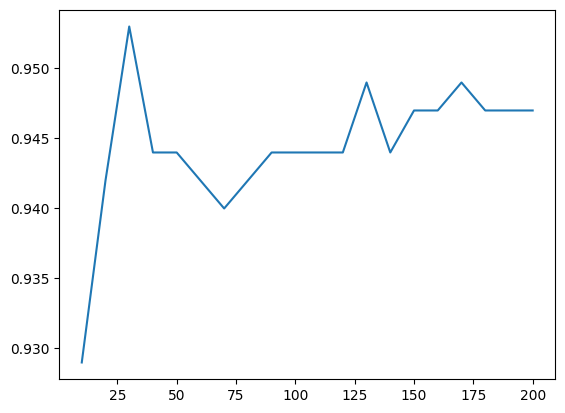

In [345]:
#@ INSPECTING THE ACCURACY SCORES:
plt.plot(df_scores.n_estimators, df_scores.accuracy.round(3))
plt.show()

In [346]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([5, 10, 15, 20, 25]):
    rf = RandomForestClassifier(n_estimators=0,
                               max_depth=d,
                               random_state=1,
                               n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


In [347]:
df_scores.max_depth.unique()

array([ 5, 10, 15, 20, 25])

In [348]:
df_scores.sort_values('accuracy', ascending=False).head()

,max_depth,n_estimators,accuracy
42,15,30,0.953229
82,25,30,0.953229
62,20,30,0.953229
22,10,30,0.948775
92,25,130,0.948775


In [379]:
#@ PLOTTING THE GRAPH:
for d in [5, 10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    print(df_subset)
    plt.plot(df_subset.n_estimators, df_subset.accuracy, label=d)

plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'max_depth'

In [350]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestClassifier(n_estimators=20, max_depth=10, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
     

RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1, random_state=1)

In [351]:
y_pred = rf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(acc)

0.9309576837416481


In [352]:
roc_auc_score(y_val, y_pred)

0.9305240087666866

In [353]:
#@ INSPECTING FEATURE IMPORTANCE:
rf.feature_importances_

array([0.02050573, 0.02198983, 0.02588956, 0.06346473, 0.02003587,
       0.01577452, 0.01747713, 0.01461506, 0.01548236, 0.09951968,
       0.02811305, 0.03295818, 0.11849603, 0.03012202, 0.09221831,
       0.3323671 , 0.05097086])

In [354]:
#@ INSPECTING FEATURE IMPORTANCES:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,%D14,0.020506
1,%D7,0.021990
2,%K14,0.025890
3,%K30,0.063465
4,%K7,0.020036
5,EMA14,0.015775
6,EMA30,0.017477
7,EMA7,0.014615
8,MOM14,0.015482
9,MOM30,0.099520


In [355]:
#@ SORTING THE VALUES:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
15,RSI30,0.332367
12,ROC30,0.118496
9,MOM30,0.099520
14,RSI14,0.092218
3,%K30,0.063465


#### XGBoot

In [357]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [358]:
#@ INITIALIZATION:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [359]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 2,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=1, evals=watchlist)

In [360]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9883841402669855

In [361]:
print(output.stdout)

[0]	train-auc:0.98558	val-auc:0.95875
[1]	train-auc:0.98918	val-auc:0.96721
[2]	train-auc:0.99543	val-auc:0.96884
[3]	train-auc:0.99732	val-auc:0.97369
[4]	train-auc:0.99793	val-auc:0.97617
[5]	train-auc:0.99838	val-auc:0.97711
[6]	train-auc:0.99880	val-auc:0.97881
[7]	train-auc:0.99915	val-auc:0.97990
[8]	train-auc:0.99928	val-auc:0.98045
[9]	train-auc:0.99934	val-auc:0.98085
[10]	train-auc:0.99945	val-auc:0.98100
[11]	train-auc:0.99949	val-auc:0.98186
[12]	train-auc:0.99952	val-auc:0.98224
[13]	train-auc:0.99967	val-auc:0.98412
[14]	train-auc:0.99977	val-auc:0.98414
[15]	train-auc:0.99984	val-auc:0.98573
[16]	train-auc:0.99986	val-auc:0.98571
[17]	train-auc:0.99987	val-auc:0.98561
[18]	train-auc:0.99987	val-auc:0.98591
[19]	train-auc:0.99990	val-auc:0.98617
[20]	train-auc:0.99989	val-auc:0.98633
[21]	train-auc:0.99990	val-auc:0.98671
[22]	train-auc:0.99992	val-auc:0.98675
[23]	train-auc:0.99993	val-auc:0.98681
[24]	train-auc:0.99995	val-auc:0.98643
[25]	train-auc:0.99996	val-auc:0.98

In [362]:
#@ DEFINING THE FUNCTION:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [363]:
df_scores = parse_xgb_output(output)
df_scores

,num_iter,train_auc,val_auc
0,0,0.98558,0.95875
1,1,0.98918,0.96721
2,2,0.99543,0.96884
3,3,0.99732,0.97369
4,4,0.99793,0.97617
...,...,...,...
95,95,1.00000,0.98838
96,96,1.00000,0.98826
97,97,1.00000,0.98834
98,98,1.00000,0.98846


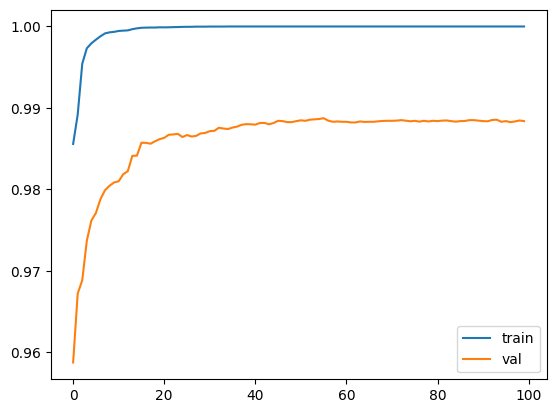

In [364]:
plt.plot(df_scores.num_iter, df_scores.train_auc, label='train')
plt.plot(df_scores.num_iter, df_scores.val_auc, label='val')
plt.legend()

In [365]:
#@ STORING:
scores['eta=0.3'] = parse_xgb_output(output)

In [366]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=1, evals=watchlist)

In [367]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9868698944012751

In [368]:
#@ STORING:
scores['eta=0.1'] = parse_xgb_output(output)

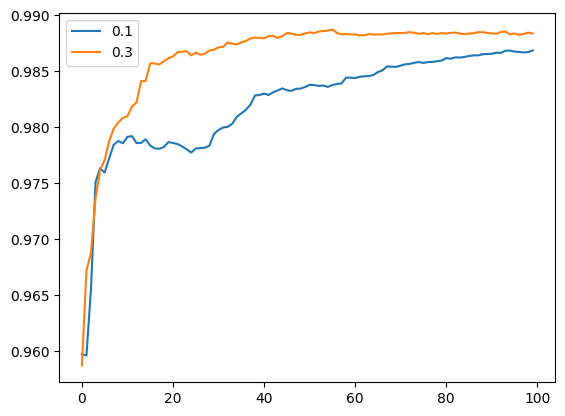

In [369]:
#@ INSPECTION:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

In [370]:
scores = {}

In [374]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=1, evals=watchlist)

In [375]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

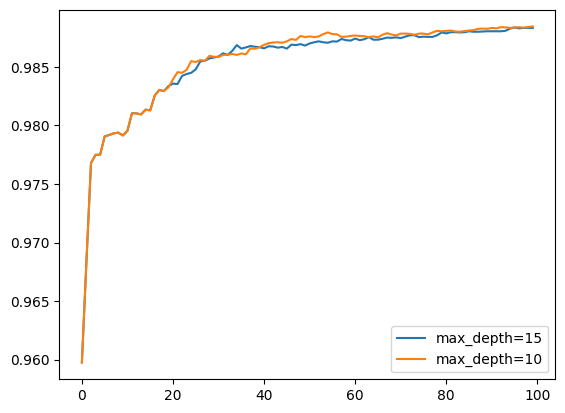

In [376]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

### Final model

In [381]:
#@ split_data
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train_full = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train_full), len(df_test)

(1347, 360)

In [382]:
y_train_full = df_train_full.signals.values
y_test = df_test.signals.values

In [383]:
train_dict = df_train_full[features].to_dict(orient="records")
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

test_dict = df_test[features].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [384]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train_full, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [385]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=1)

In [388]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.9878359880537582

### Saving the model

In [390]:
# import joblib

# joblib.dump(dv, 'dv.pkl')
# joblib.dump(model, 'xgb_model.pkl')